### Importing the Libraries

In [318]:
# Load essential libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import glob,string
import codecs
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset



In [284]:
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        prefix = file.split("/")[-1].split("__")[0]
        label = int(prefix.lstrip(string.ascii_letters)) -1 # for zero-based for pytorch crossentropy
        data.append((file,label,prefix))
    return pd.DataFrame(data,columns=['path','label','class'])


In [285]:
class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df = dataframe.reset_index(drop=True)
        self.paths = df["path"].tolist()
        self.targets = df["label"].astype(int).tolist()
        self.transform = transform

        label_to_class = dict(zip(df["label"], df["class"]))
        self.classes = [label_to_class[i] for i in sorted(label_to_class.keys())]
        self.class_to_idx = {name: i for i, name in enumerate(self.classes)}

    def __len__(self): 
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.targets[idx], dtype=torch.long)

### Loading the Dataset Coil-100 dataset

In [310]:
def get_coil100_train_valid_loader(batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    
    path = 'coil-100/*.png'
    files=glob.glob(path)
    
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = CreateDataset(contructDataframe(files), transform=transform)
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   
    train_size = int(percent_train * dataset_size)   # 70%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, valid_loader, test_loader, classes



### Loading the Dataset EuroSAT dataset

In [308]:
def get_EuroSAT_train_valid_loader(data_dir, batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    # Define transforms (resize + normalization) ---
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
       # transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform,)
    print(type(dataset))
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   # ~27,000 images
    train_size = int(percent_train * dataset_size)   # 70%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return (train_loader, valid_loader, test_loader, classes)


In [309]:
# load EuroSAT dataset
train_loader, valid_loader, test_loader, classes = get_EuroSAT_train_valid_loader(data_dir = './data',batch_size = 32, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)

<class 'torchvision.datasets.eurosat.EuroSAT'>
torch.Size([32, 3, 64, 64])


In [311]:
# load Coil-100 dataset
train_loader, valid_loader, test_loader, classes = get_coil100_train_valid_loader(batch_size = 32, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)


100%|██████████| 7200/7200 [00:00<00:00, 1203434.64it/s]

torch.Size([32, 3, 64, 64])


### Visualize images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83536816..2.304582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70060635..2.4932485].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6736541..2.032703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7545111..2.0112967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.4662962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7545111..2.398915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6467017

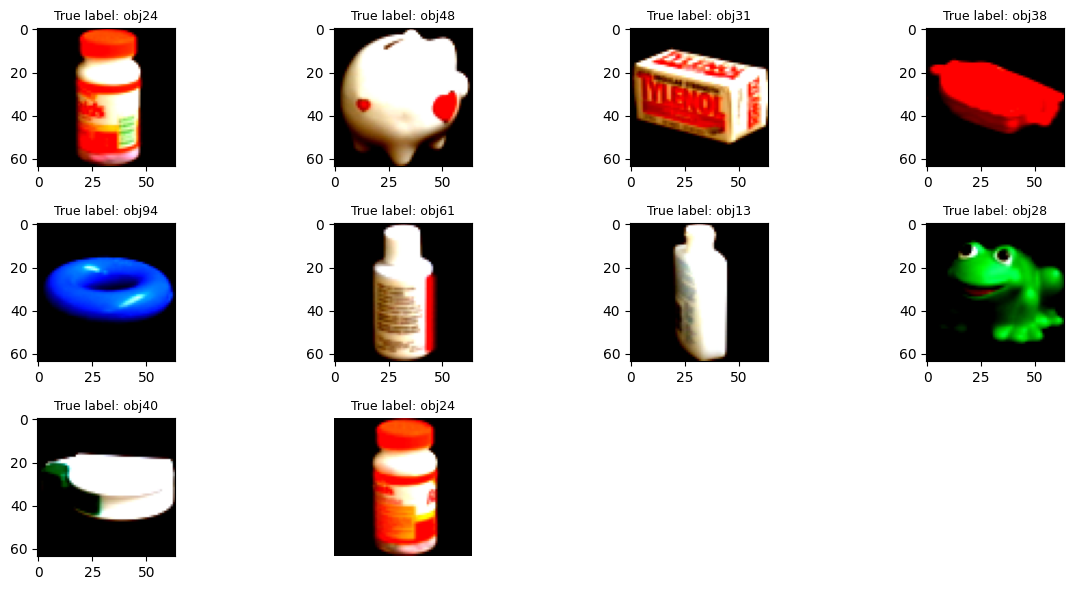

In [312]:
# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

# Denormalize helper
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img

# Plot some images
def plot_images(images, labels, classes, preds=None, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.ceil(num_images/np.sqrt(num_images))), i+1)
        img = images[i]
        img = denormalize(img)
        npimg = img.permute(1, 2, 0).numpy()
        plt.imshow(npimg)
      
        true_label = classes[labels[i]]
        if preds is not None:
            pred_label = classes[preds[i]]
            title = f"True label: {true_label}\nPredicted label: {pred_label}"
            color = "green" if labels[i] == preds[i] else "red"
            plt.title(title, color=color, fontsize=9)
        else:
            plt.title(f"True label: {true_label}", fontsize=9)

    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_images(images, labels, classes, num_images=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6601778..2.304582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6467017..2.385439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7140826..2.032703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6736541..2.4528198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72755873..2.3584867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8757967..2.2681682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86232054

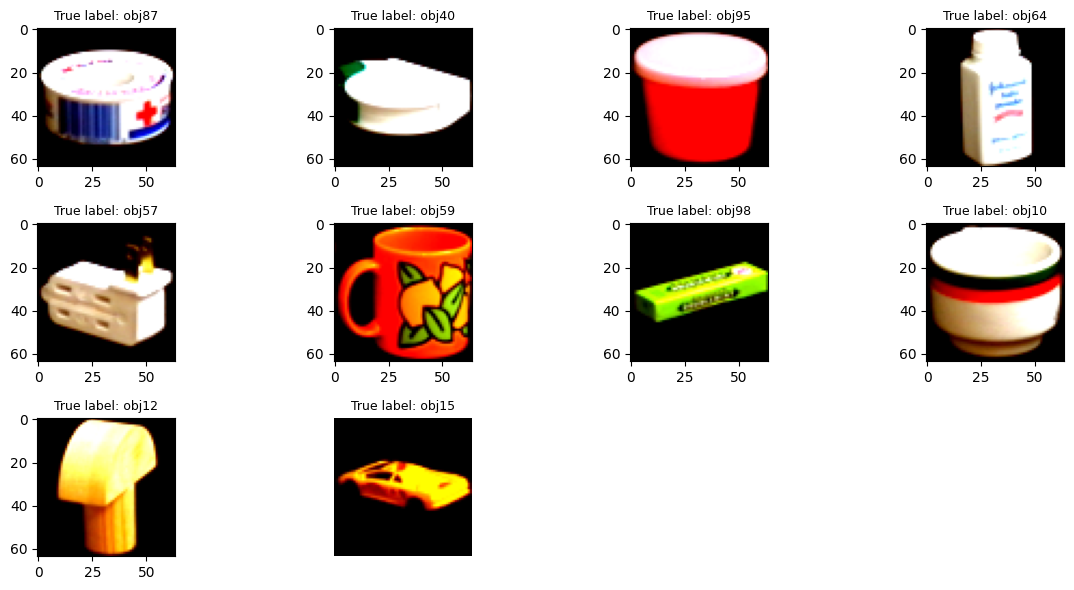

In [313]:
# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_images(images, labels, classes, num_images=10)

In [317]:
images = images.view(images.shape[0], -1)
print(images.shape)


num_classes = len(classes)
print(num_classes)

torch.Size([32, 12288])
100


In [319]:
class BaseANN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lin1 = nn.Linear(in_features=12288, out_features=64)
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(in_features=64, out_features=32)
        self.drop2 = nn.Dropout(p=0.3)
        self.lin3 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x):
        # Complete the forward pass function for the ANN
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x))
        x = self.drop2(x)
        x = self.lin3(x)
        return x
 
        

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # TODO: implement your CNN architecture as defined in the instructions
        pass
        

    def forward(self, x):
        # Complete the forward pass function for the CNN
        pass
        


In [333]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)
model = BaseANN(num_classes=len(classes)).to(device)

#model = BaseCNN(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Train and validate your CNN model

In [335]:
def train(model, train_loader, valid_loader, num_epochs=10):
  train_losses, valid_losses = [], []
  model.train()

  for epoch in range(num_epochs):
    running_loss = 0.0
    total_samples = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      # Flatten only when model expects flattened input (ANN)
      if images.dim() > 2 and isinstance(model, BaseANN):
        images = images.view(images.shape[0], -1)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_size = labels.size(0)
      running_loss += loss.item() * batch_size
      total_samples += batch_size

    epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0.0
    train_losses.append(epoch_train_loss)

    # Validation after each epoch
    val_loss, val_acc = evaluate(model, valid_loader)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

  plot_loss(train_losses, valid_losses)
  return train_losses, valid_losses

### Test your model

In [330]:
def plot_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [329]:
# --- Evaluation ---
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # If model expects flattened input (ANN), flatten; CNNs will ignore if already correct
            if images.dim() > 2:
                images = images.view(images.shape[0], -1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
    model.train()
    return avg_loss, accuracy


Epoch 1/100 - Train Loss: 1.8266 - Val Loss: 0.8830 - Val Acc: 75.93%
Epoch 2/100 - Train Loss: 1.7994 - Val Loss: 0.9215 - Val Acc: 77.59%
Epoch 3/100 - Train Loss: 1.7759 - Val Loss: 0.8219 - Val Acc: 80.93%
Epoch 4/100 - Train Loss: 1.7293 - Val Loss: 0.7836 - Val Acc: 81.48%
Epoch 5/100 - Train Loss: 1.7034 - Val Loss: 0.7853 - Val Acc: 80.93%
Epoch 6/100 - Train Loss: 1.6567 - Val Loss: 0.7891 - Val Acc: 82.22%
Epoch 7/100 - Train Loss: 1.6728 - Val Loss: 0.7821 - Val Acc: 82.41%
Epoch 8/100 - Train Loss: 1.6860 - Val Loss: 0.7655 - Val Acc: 83.61%
Epoch 9/100 - Train Loss: 1.6050 - Val Loss: 0.7206 - Val Acc: 83.52%
Epoch 10/100 - Train Loss: 1.6496 - Val Loss: 0.7979 - Val Acc: 81.85%
Epoch 11/100 - Train Loss: 1.6357 - Val Loss: 0.6837 - Val Acc: 84.35%
Epoch 12/100 - Train Loss: 1.5850 - Val Loss: 0.7072 - Val Acc: 82.41%
Epoch 13/100 - Train Loss: 1.5528 - Val Loss: 0.6743 - Val Acc: 85.00%
Epoch 14/100 - Train Loss: 1.5252 - Val Loss: 0.6947 - Val Acc: 86.11%
Epoch 15/100 - 

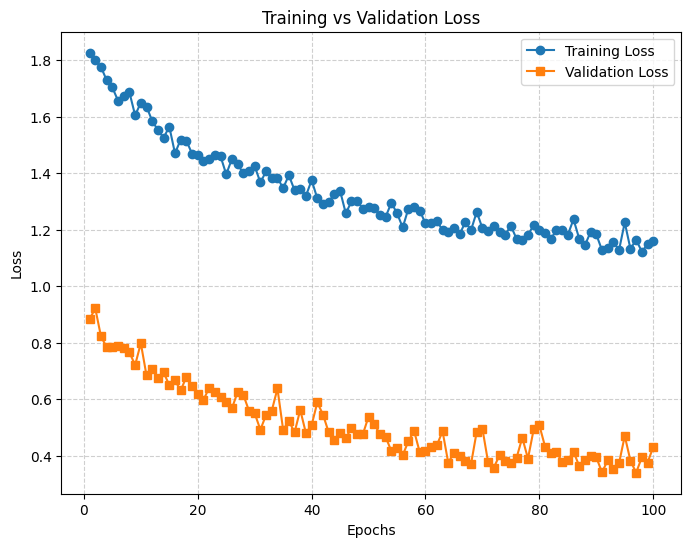

Test Accuracy: 91.39%


In [ ]:
# --- Run training ---
train(model, train_loader, valid_loader, num_epochs=10)

# --- Test accuracy ---
_,test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

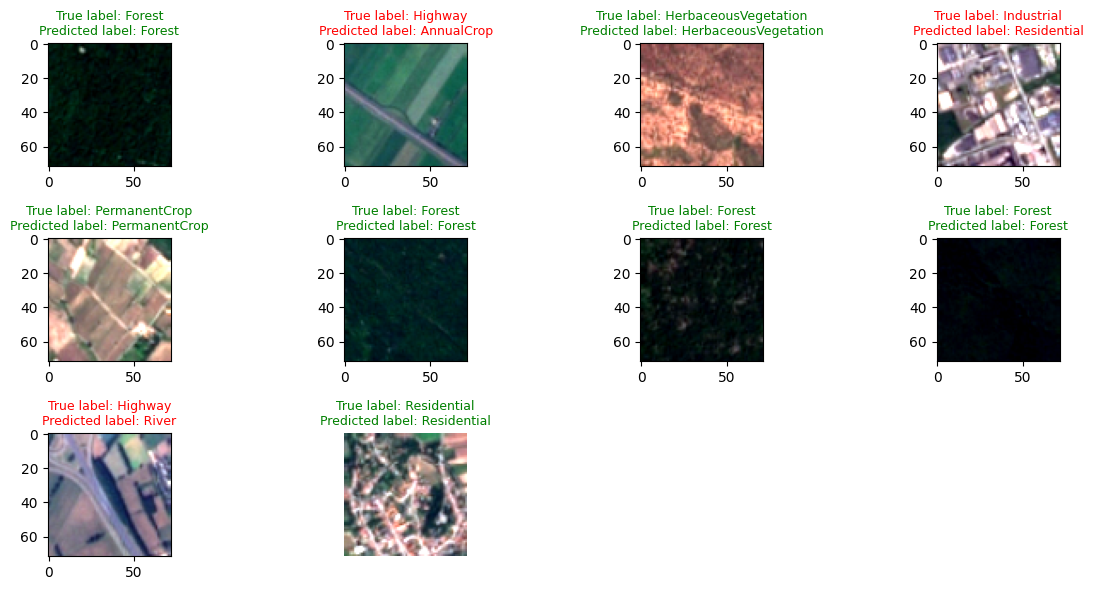

In [ ]:
# Show test images with predictions
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plot_images(images.cpu(), labels, classes, preds=preds.cpu(), num_images=10)


### Provide your answers to Experiment and Reflection

- What choices affect the model's accuracy?
- How do you determine whether the model is  overfitting or underfitting?
- What happens when you add or remove components, for example, dropout or batch normalization?
- What layer causes the highest number of parameters?
- what happens if you remove all pooling layers in a CNN?
- In a CNN block, can you arrange the layer (i.e. Conv, ReLU, BatchNorm, Dropout) in any order? Explain your answer.